# LeR Advanced Sampling — Generating Detectable Events

This notebook is created by [Phurailatpam Hemantakumar](https://hemantaph.com)

[![Documentation](https://img.shields.io/badge/ler-documentation-blue)](https://ler.hemantaph.com) 

This notebook demonstrates how to generate a specific number of detectable events and monitor detection rate convergence as a function of sample size using the `LeR` class.

**Key Features:**
- Batch sampling until N detectable events are collected
- Rate convergence monitoring with stopping criteria
- Resume capability for interrupted sessions
- Visualization of rate convergence and parameter distributions

---

## Table of Contents

1. [Initialize LeR](#1-initialize-ler)
2. [Sampling N Detectable Events](#2-sampling-n-detectable-events)
   - [2.1 Unlensed Events](#2-1-unlensed-events)
   - [2.2 Rate Convergence (Unlensed)](#2-2-rate-convergence-unlensed)
   - [2.3 Rate Stability (Unlensed)](#2-3-rate-stability-unlensed)
   - [2.4 Lensed Events](#2-4-lensed-events)
   - [2.5 Rate Convergence (Lensed)](#2-5-rate-convergence-lensed)
   - [2.6 Rate Stability (Lensed)](#2-6-rate-stability-lensed)
   - [2.7 Rate Comparison](#2-7-rate-comparison)
3. [Parameter Distributions: All vs Detectable](#3-parameter-distributions-all-vs-detectable)
   - [3.1 Unlensed Events](#3-1-unlensed-events)
   - [3.2 Lensed Events](#3-2-lensed-events)
4. [Visualizing Lensed Detectable Events](#4-visualizing-lensed-detectable-events)
   - [4.1 Redshift Distribution](#4-1-redshift-distribution)
   - [4.2 Magnification Ratio vs Time Delay](#4-2-magnification-ratio-vs-time-delay)
   - [4.3 Caustic Plot](#4-3-caustic-plot)
5. [Summary](#summary)

---

## 1. Initialize LeR

The `LeR` class is the main interface for simulating unlensed and lensed GW events and calculating detection rates. Default settings:

- **Event type:** BBH (Binary Black Hole)
- **Lens model:** EPL+Shear (Elliptical Power Law with external shear)
- **Detectors:** H1, L1, V1 with O4 design sensitivity

Outputs are saved to `./ler_data` by default.

In [1]:
# Import LeR
from ler.rates import LeR

# Initialize LeR with default settings
# npool: number of parallel processes for sampling
ler = LeR(npool=6)


Initializing LeR class...


Initializing LensGalaxyParameterDistribution class...


Initializing OpticalDepth class

comoving_distance interpolator will be loaded from ./interpolator_json/comoving_distance/comoving_distance_0.json
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.json
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.json
differential_comoving_volume interpolator will be loaded from ./interpolator_json/differential_comoving_volume/differential_comoving_volume_0.json
using ler available velocity dispersion function : velocity_dispersion_ewoud
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_json/velocity_dispersion/velocity_dispersion_ewoud_0.json
using ler available axis_ratio function : axis_ratio_rayleigh
axis_ratio_rayleigh interpolator will be loaded from ./interpolator_json/a

```python
# To print all initialization input arguments, use:
ler._print_all_init_args()
```

---

## 2. Sampling N Detectable Events

Sample GW events until a specified number of detectable events is collected and stopping criteria are met.

**Key features:**
- **Batch processing:** Events are sampled in batches for efficiency
- **Convergence monitoring:** Rate stability is tracked via stopping criteria
- **Resume capability:** Sampling can continue from previous sessions

### 2.1 Unlensed Events

Key parameters:
- `size`: Target number of detectable events
- `batch_size`: Events sampled per batch
- `stopping_criteria`: Convergence conditions
- `pdet_threshold`: Detection probability threshold
- `resume`: Resume from previous session

In [ ]:
# Sample until we have at least 10,000 detectable unlensed events with converged rates
# use 'print(ler.selecting_n_unlensed_detectable_events.__doc__)' to see all input args
detectable_rate_unlensed, unlensed_param_detectable_n = ler.selecting_n_unlensed_detectable_events(
    size=10000,                          # Target number of detectable events
    batch_size=100000,                   # Events per batch
    stopping_criteria=dict(
        relative_diff_percentage=0.1,    # Stop when rate change < 0.1%
        number_of_last_batches_to_check=4  # Check last 4 batches for convergence
    ),
    pdet_threshold=0.5,                  # Probability threshold for detection
    resume=True,                         # Resume from previous state if available
    output_jsonfile='unlensed_params_n_detectable.json',  # Output file for detectable events
    meta_data_file='meta_unlensed.json', # Store metadata (rates per batch)
    pdet_type='boolean',                 # Detection type: 'boolean' or 'float'
    trim_to_size=False,                  # Keep all events found until convergence
)

print(f"\n=== Unlensed N-Event Sampling Results ===")
print(f"Detectable event rate: {detectable_rate_unlensed:.4e} events per year")
print(f"Total detectable events collected: {len(unlensed_param_detectable_n['zs'])}")

### 2.2 Rate Convergence (Unlensed)

Visualize how detection rate evolves with sample size. A converged rate indicates stable statistics.

In [ ]:
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

# Load metadata containing rates for each batch
meta_data = get_param_from_json(ler.ler_directory + '/meta_unlensed.json')

# Plot rate vs sampling size
plt.figure(figsize=(8, 5))
plt.plot(
    meta_data['events_total'],
    meta_data['total_rate'],
    'o-',
    linewidth=2,
    markersize=6,
    color='C0',
    label='Detectable rate'
)

plt.xlabel('Total Number of Events Sampled', fontsize=12)
plt.ylabel('Detectable Event Rate (per year)', fontsize=12)
plt.title('Unlensed Rate Convergence Across Batches', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.xscale('log')
plt.tight_layout()
plt.show()

### 2.3 Rate Stability (Unlensed)

Quantify convergence using mean and standard deviation from the last few batches.

In [ ]:
import numpy as np

# Select rates from the last 4 batches
idx_converged = [-4, -3, -2, -1]
rates_converged = np.array(meta_data['total_rate'])[idx_converged]

if len(rates_converged) > 0:
    mean_rate = rates_converged.mean()
    std_rate = rates_converged.std()
    
    print(f"=== Unlensed Rate Stability Analysis ===")
    print(f"Number of batches analyzed: {len(rates_converged)}")
    print(f"Mean rate: {mean_rate:.4e} events/year")
    print(f"Standard deviation: {std_rate:.4e} events/year")
    print(f"Relative uncertainty: {(std_rate/mean_rate)*100:.3f}%")
else:
    print("Not enough batches to assess convergence.")

# Update the rate with the converged mean
detectable_rate_unlensed = mean_rate

### 2.4 Lensed Events

Generate lensed detectable events. For lensed events, we can specify:
- `pdet_threshold`: List of detection thresholds for each image
- `num_img`: Number of images that must meet each corresponding threshold

Here, `stopping_criteria=None` with `size=1000` means sampling continues until at least 1000 detectable lensed events are collected.

In [ ]:
# Sample until we have at least 1,000 detectable lensed events
# use 'print(ler.selecting_n_lensed_detectable_events.__doc__)' to see all input args
detectable_rate_lensed, lensed_param_detectable_n = ler.selecting_n_lensed_detectable_events(
    size=1000,                           # Target number of detectable events
    batch_size=50000,                    # Events per batch
    stopping_criteria=None,              # No stopping criteria (sample until size is reached)
    pdet_threshold=[0.5, 0.5],           # Detection thresholds for images
    num_img=[1, 1],                      # Number of images required per threshold
    resume=True,                        # Resume from previous state if available
    output_jsonfile='lensed_params_n_detectable.json',
    meta_data_file='meta_lensed.json',
    pdet_type='boolean',
    trim_to_size=False,
)

print(f"\n=== Lensed N-Event Sampling Results ===")
print(f"Detectable event rate: {detectable_rate_lensed:.4e} events per year")
print(f"Total detectable events collected: {len(lensed_param_detectable_n['zs'])}")

### 2.5 Rate Convergence (Lensed)

Visualize the lensed detection rate evolution across batches.

In [ ]:
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

# Load metadata containing rates for each batch
meta_data = get_param_from_json(ler.ler_directory + '/meta_lensed.json')

# Plot rate vs sampling size
plt.figure(figsize=(8, 5))
plt.plot(
    meta_data['events_total'],
    meta_data['total_rate'],
    'o-',
    linewidth=2,
    markersize=6,
    color='C1',
    label='Detectable rate'
)

plt.xlabel('Total Number of Events Sampled', fontsize=12)
plt.ylabel('Detectable Event Rate (per year)', fontsize=12)
plt.title('Lensed Rate Convergence Across Batches', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.xscale('log')
plt.tight_layout()
plt.show()

### 2.6 Rate Stability (Lensed)

Quantify convergence using mean and standard deviation from the last few batches.

In [ ]:
import numpy as np

# Select rates from the last 4 batches
idx_converged = [-4, -3, -2, -1]
rates_converged = np.array(meta_data['total_rate'])[idx_converged]

if len(rates_converged) > 0:
    mean_rate = rates_converged.mean()
    std_rate = rates_converged.std()
    
    print(f"=== Lensed Rate Stability Analysis ===")
    print(f"Number of batches analyzed: {len(rates_converged)}")
    print(f"Mean rate: {mean_rate:.4e} events/year")
    print(f"Standard deviation: {std_rate:.4e} events/year")
    print(f"Relative uncertainty: {(std_rate/mean_rate)*100:.3f}%")
else:
    print("Not enough batches to assess convergence.")

# Update the rate with the converged mean
detectable_rate_lensed = mean_rate

### 2.7 Rate Comparison

Compare detection rates between lensed and unlensed events.

In [ ]:
# Compare lensed vs unlensed rates
print(f"=== Detection Rate Comparison ===")
print(f"Unlensed detectable rate: {detectable_rate_unlensed:.4e} events/year")
print(f"Lensed detectable rate:   {detectable_rate_lensed:.4e} events/year")
print(f"Ratio (Unlensed/Lensed):  {(detectable_rate_unlensed/detectable_rate_lensed):.2f}")

---

## 3. Parameter Distributions: All vs Detectable

Compare parameter distributions between all sampled events and detectable events. Corner plots reveal **selection effects** introduced by detector sensitivity.

### 3.1 Unlensed Events

Generate a large sample of all unlensed events (both detectable and non-detectable) for comparison.

In [ ]:
# Generate a large sample of all unlensed events for comparison
unlensed_param = ler.unlensed_cbc_statistics(size=50000, resume=True, output_jsonfile='unlensed_params_all.json')

print(f"Total unlensed events sampled: {len(unlensed_param['zs'])}")

Corner plot comparing all sampled events vs detectable events:

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

# Load data
param = get_param_from_json('./ler_data/unlensed_params_all.json')
param_detectable = get_param_from_json('./ler_data/unlensed_params_n_detectable.json')

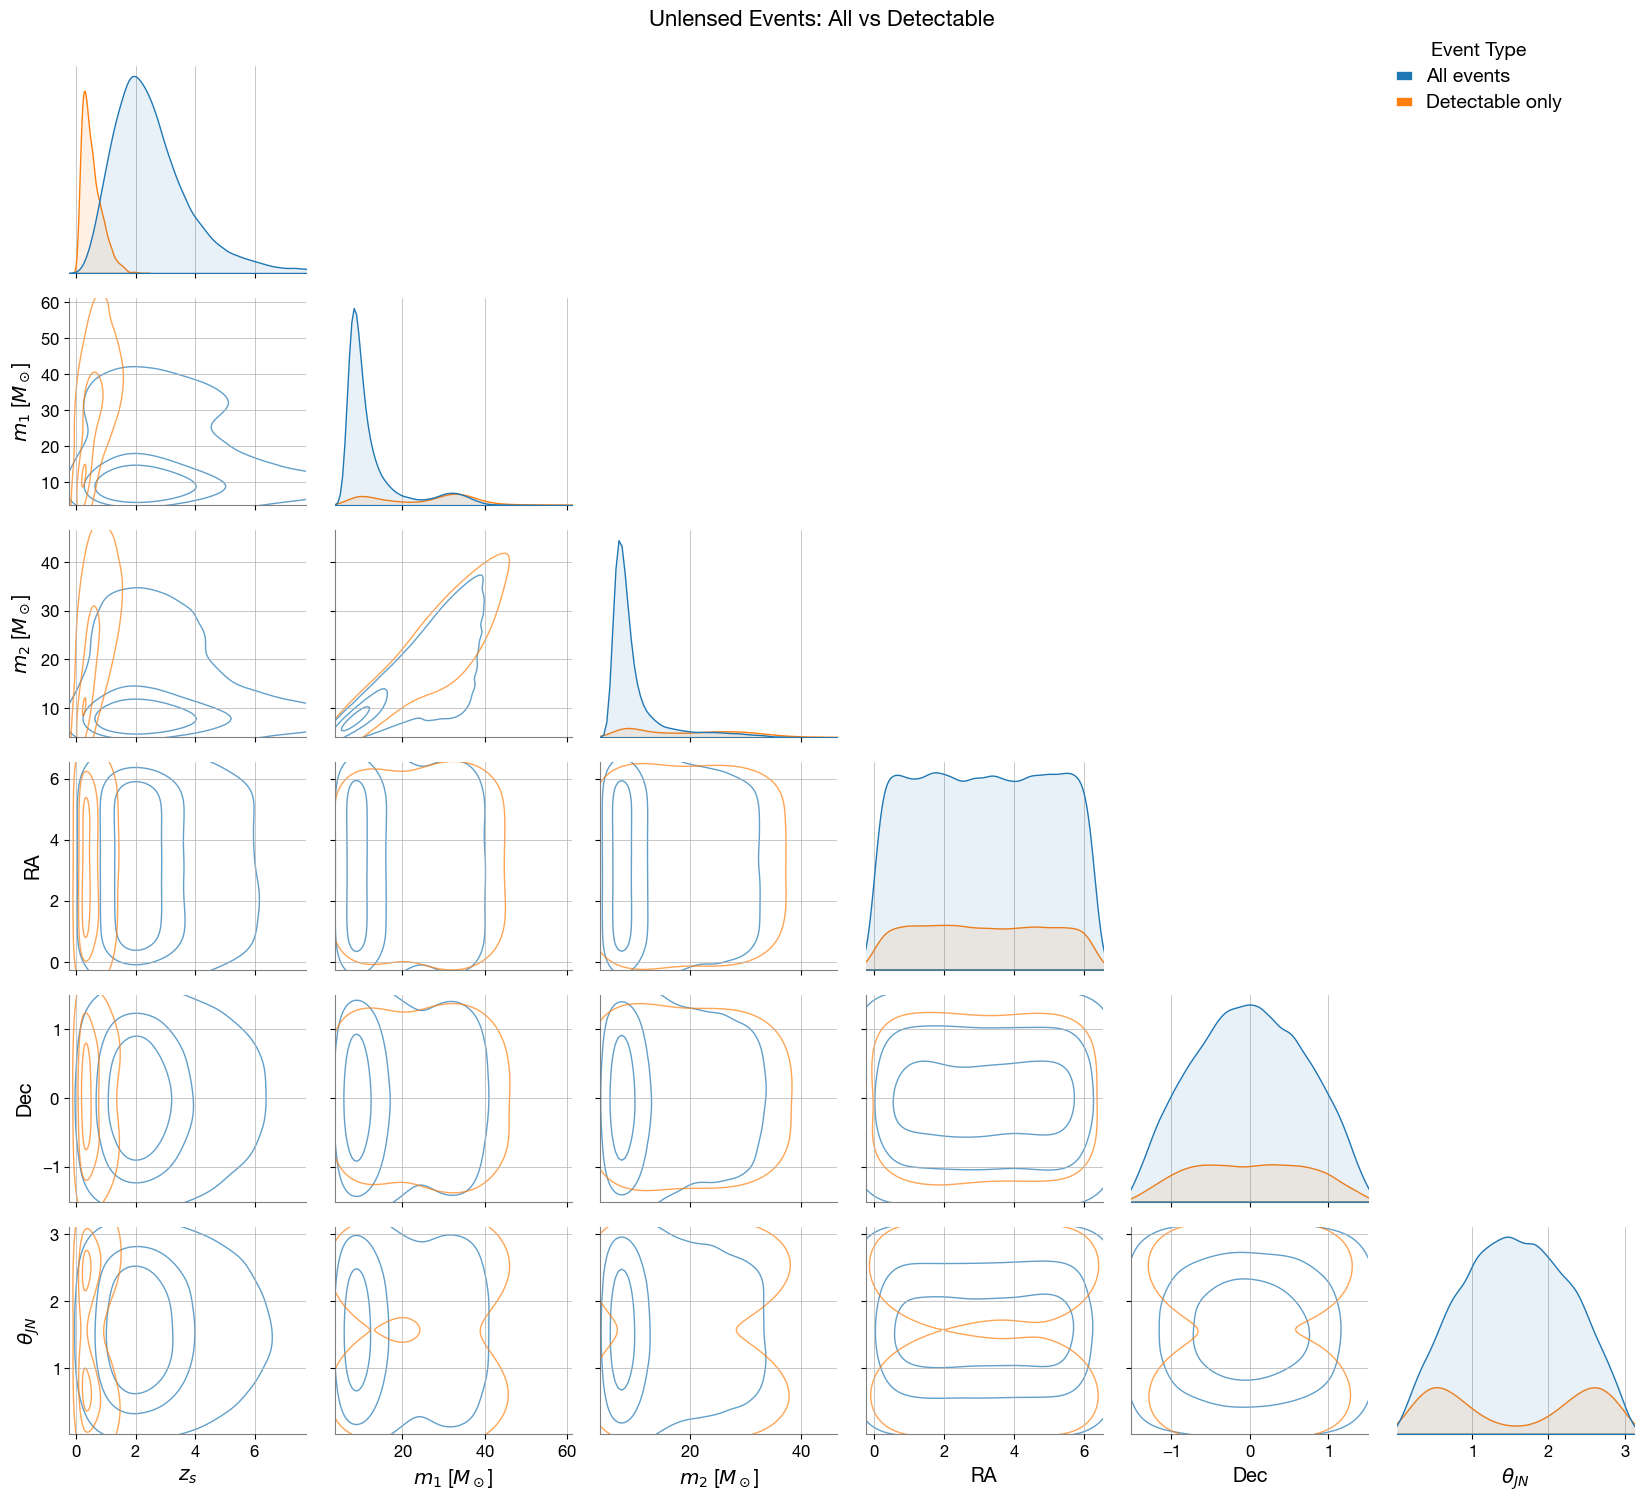

In [2]:


# Parameters to compare
param_names = ['zs', 'mass_1_source', 'mass_2_source', 'ra', 'dec', 'theta_jn']
labels = ['$z_s$', '$m_1$ [$M_\odot$]', '$m_2$ [$M_\odot$]', 'RA', 'Dec', r'$\theta_{JN}$']

# Create DataFrames
df_all = pd.DataFrame({label: param[name] for name, label in zip(param_names, labels)})
df_all['Event Type'] = 'All events'

df_detectable = pd.DataFrame({label: param_detectable[name] for name, label in zip(param_names, labels)})
df_detectable['Event Type'] = 'Detectable only'

# Combine DataFrames
df_combined = pd.concat([df_all, df_detectable], ignore_index=True)

# Calculate 1st and 99th percentiles for each parameter to set limits
percentile_limits = {}
for label in labels:
    lower = np.percentile(df_combined[label], 1)
    upper = np.percentile(df_combined[label], 99)
    # Add some padding (5% of range)
    range_pad = (upper - lower) * 0.05
    percentile_limits[label] = (lower - range_pad, upper + range_pad)

# Create pairplot with corner=True and contour plots
g = sns.pairplot(
    df_combined, 
    hue='Event Type',
    palette={'All events': 'C0', 'Detectable only': 'C1'},
    corner=True,
    kind='kde',  # Use KDE for 2D contour plots
    plot_kws={'alpha': 0.7, 'levels': 4, 'linewidths': 1.0, 'bw_adjust': 1.8},  # bw_adjust for smoother KDE
    diag_kind='kde',
    diag_kws={'alpha': 0.1, 'linewidth': 1.0}  # Reduced opacity for diagonal histograms
)

# Apply limits to all subplots
for i, row_label in enumerate(labels):
    for j, col_label in enumerate(labels):
        if i > j:  # Only lower triangle (corner plot)
            ax = g.axes[i, j]
            ax.set_xlim(percentile_limits[col_label])
            ax.set_ylim(percentile_limits[row_label])
        elif i == j:  # Diagonal
            ax = g.axes[i, j]
            ax.set_xlim(percentile_limits[row_label])

# Update legend
g._legend.set_title('Event Type')
g._legend.get_title().set_fontsize(14)
g._legend.set_bbox_to_anchor((0.95, 0.95))
for text in g._legend.get_texts():
    text.set_fontsize(14)

# Add title
g.fig.suptitle('Unlensed Events: All vs Detectable', fontsize=16, y=1.0)
g.fig.tight_layout()

plt.show()

size : 5000


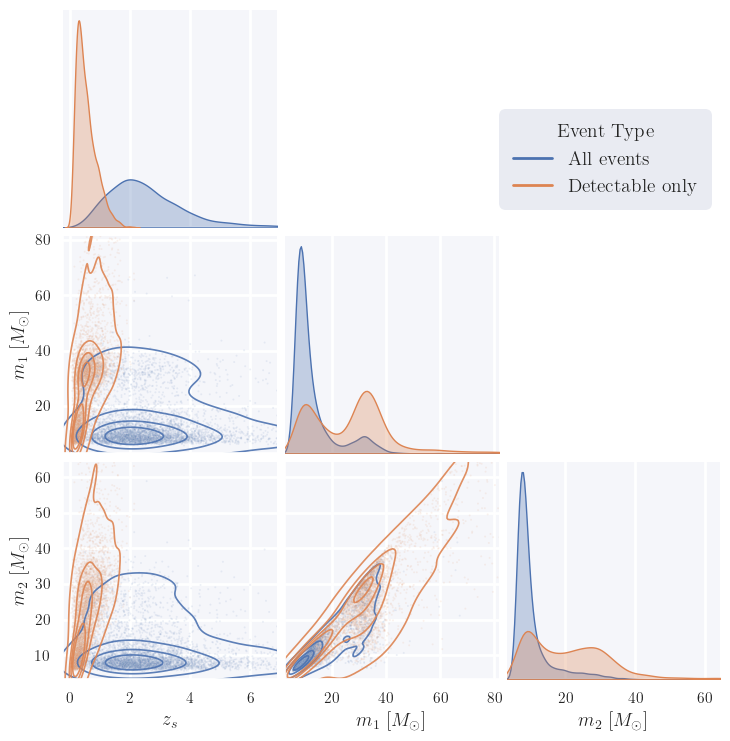

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

# Reset to defaults (optional but good if you've been tweaking rcParams a lot)
mpl.rcParams.update(mpl.rcParamsDefault)
LIGHT_BG = "#F5F6FA"

# --- Seaborn grey background + white grid ---
sns.set_theme(
    style="darkgrid",   # grey background
    context="notebook",
    rc={
        # background
        "axes.facecolor": LIGHT_BG,   # seaborn-like grey
        "figure.facecolor": "white",
        # grid (white lines)
        "axes.grid": True,
        "grid.color": "white",
        "grid.linestyle": "-",
        "grid.linewidth": 2.0,
        "grid.alpha": 1.0,
        # keep grid behind artists
        "axes.axisbelow": True,
        # ticks (optional, helps readability on grey bg)
        "xtick.direction": "out",
        "ytick.direction": "out",
    }
)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "custom",
    "savefig.dpi": 300,
})

# Parameters to compare
param_names = ['zs', 'mass_1_source', 'mass_2_source']
labels = ['$z_s$', '$m_1$ [$M_\\odot$]', '$m_2$ [$M_\\odot$]']

size = 5000
size = len(param_detectable[param_names[0]]) if len(param_detectable[param_names[0]]) < size else size

# Create DataFrames
indices = np.random.choice(len(param_detectable[param_names[0]]), size=size, replace=False)
df_detectable = pd.DataFrame({label: param_detectable[name][indices] for name, label in zip(param_names, labels)})
df_detectable['Event Type'] = 'Detectable only'

print(f"size : {size}")

indices = np.random.choice(len(param[param_names[0]]), size=size, replace=False)
df_all = pd.DataFrame({label: param[name][indices] for name, label in zip(param_names, labels)})
df_all['Event Type'] = 'All events'

# Combine DataFrames
df_combined = pd.concat([df_detectable, df_all], ignore_index=True)

# Calculate 1st and 99th percentiles for each parameter to set limits
percentile_limits = {}
for label in labels:
    lower = np.percentile(df_combined[label], 1)
    upper = np.percentile(df_combined[label], 99)
    # Add some padding (5% of range)
    range_pad = (upper - lower) * 0.05
    percentile_limits[label] = (lower - range_pad, upper + range_pad)

# Create pairplot with both scatter and contour (KDE) for 2D plots
# First, make the scatter pairplot with smaller point size
pairplot_scatter = sns.pairplot(
    df_combined,
    hue='Event Type',
    palette={'All events': 'C0', 'Detectable only': 'C1'},
    corner=True,
    kind='scatter',
    plot_kws=dict(marker=".", alpha=0.1, s=8),  # s=8 for smaller points
    diag_kind='kde',
    diag_kws={'alpha': 0.3, 'linewidth': 1.0}
)

# Overlay KDE contours on the lower triangle
for i, row_label in enumerate(labels):
    for j, col_label in enumerate(labels):
        if i > j:
            ax = pairplot_scatter.axes[i, j]
            for event_type, color in zip(['All events', 'Detectable only'], ['C0', 'C1']):
                subset = df_combined[df_combined['Event Type'] == event_type]
                sns.kdeplot(
                    x=subset[col_label],
                    y=subset[row_label],
                    ax=ax,
                    levels=5,
                    color=color,
                    alpha=0.9,
                    linewidths=1.2,
                    bw_adjust=1.4,
                    fill=False
                )
            ax.set_xlim(percentile_limits[col_label])
            ax.set_ylim(percentile_limits[row_label])
        elif i == j:
            ax = pairplot_scatter.axes[i, j]
            ax.set_xlim(percentile_limits[row_label])

# Remove the default legend created by seaborn
if pairplot_scatter._legend is not None:
    pairplot_scatter._legend.remove()

# Custom legend with line handles instead of points
line_handles = [
    Line2D([0], [0], color='C0', lw=2, label='All events'),
    Line2D([0], [0], color='C1', lw=2, label='Detectable only')
]
leg = pairplot_scatter.fig.legend(
    handles=line_handles,
    title="Event Type",
    loc='upper right',
    bbox_to_anchor=(0.80, 0.85),
    fontsize=14,
    title_fontsize=14,
    frameon=True
)
leg.get_title().set_weight("bold")
frame = leg.get_frame()
frame.set_facecolor("#E9EBF2")
frame.set_edgecolor("none")
frame.set_linewidth(0.6)
frame.set_alpha(1.0)
frame.set_boxstyle("round,pad=0.35")

# Increase axis label font size
for ax in pairplot_scatter.fig.axes:
    ax.set_facecolor(LIGHT_BG)
    # ax.grid(True, color="black", linestyle='--', linewidth=1.0, alpha=0.1)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)

pairplot_scatter.fig.savefig("Unlensed_Events.png", bbox_inches="tight", dpi=300)
plt.show()


In [ ]:
leg = pairplot_scatter.fig.legend(
    handles=line_handles,
    title="Event Type",
    loc='upper right',
    bbox_to_anchor=(0.90, 0.90),
    fontsize=14,
    title_fontsize=14,
    frameon=True
)
leg.get_title().set_weight("bold")
frame = leg.get_frame()
frame.set_facecolor("#E9EBF2")
frame.set_edgecolor("none")
frame.set_linewidth(0.6)
frame.set_alpha(1.0)
frame.set_boxstyle("round,pad=0.35")

for ax in pairplot_scatter.fig.axes:
    ax.set_facecolor(LIGHT_BG)
    ax.grid(True, color="black", linestyle='--', linewidth=1.0, alpha=0.1)

pairplot_scatter.fig.savefig("Unlensed_Events.png", dpi=300)
plt.show()

### 3.2 Lensed Events

Compare intrinsic, strongly lensed, and detectable lensed event distributions. First, generate strongly lensed events:

In [2]:
# Generate a large sample of all lensed events for comparison
lensed_param = ler.lensed_cbc_statistics(size=50000, resume=True, output_jsonfile='lensed_params_all.json')

print(f"Total lensed events sampled: {len(lensed_param['zs'])}")

lensed params will be stored in ./ler_data/lensed_params_all.json
resuming from ./ler_data/lensed_params_all.json
lensed parameters already sampled.
saving all lensed parameters in ./ler_data/lensed_params_all.json 
Total lensed events sampled: 50000


Generate intrinsic parameters (without strong lensing selection):

In [ ]:
# Generate a large sample of all lensed events for comparison
lensed_param_intrinsic = ler.sample_all_routine_epl_shear_intrinsic(size=50000)

print(f"Total lensed events sampled: {len(lensed_param_intrinsic['zs'])}")

# save to file
from ler.utils import append_json
append_json(ler.ler_directory+'/lensed_param_intrinsic.json', lensed_param_intrinsic, replace=True);

Corner plot comparing intrinsic, strongly lensed, and detectable events:

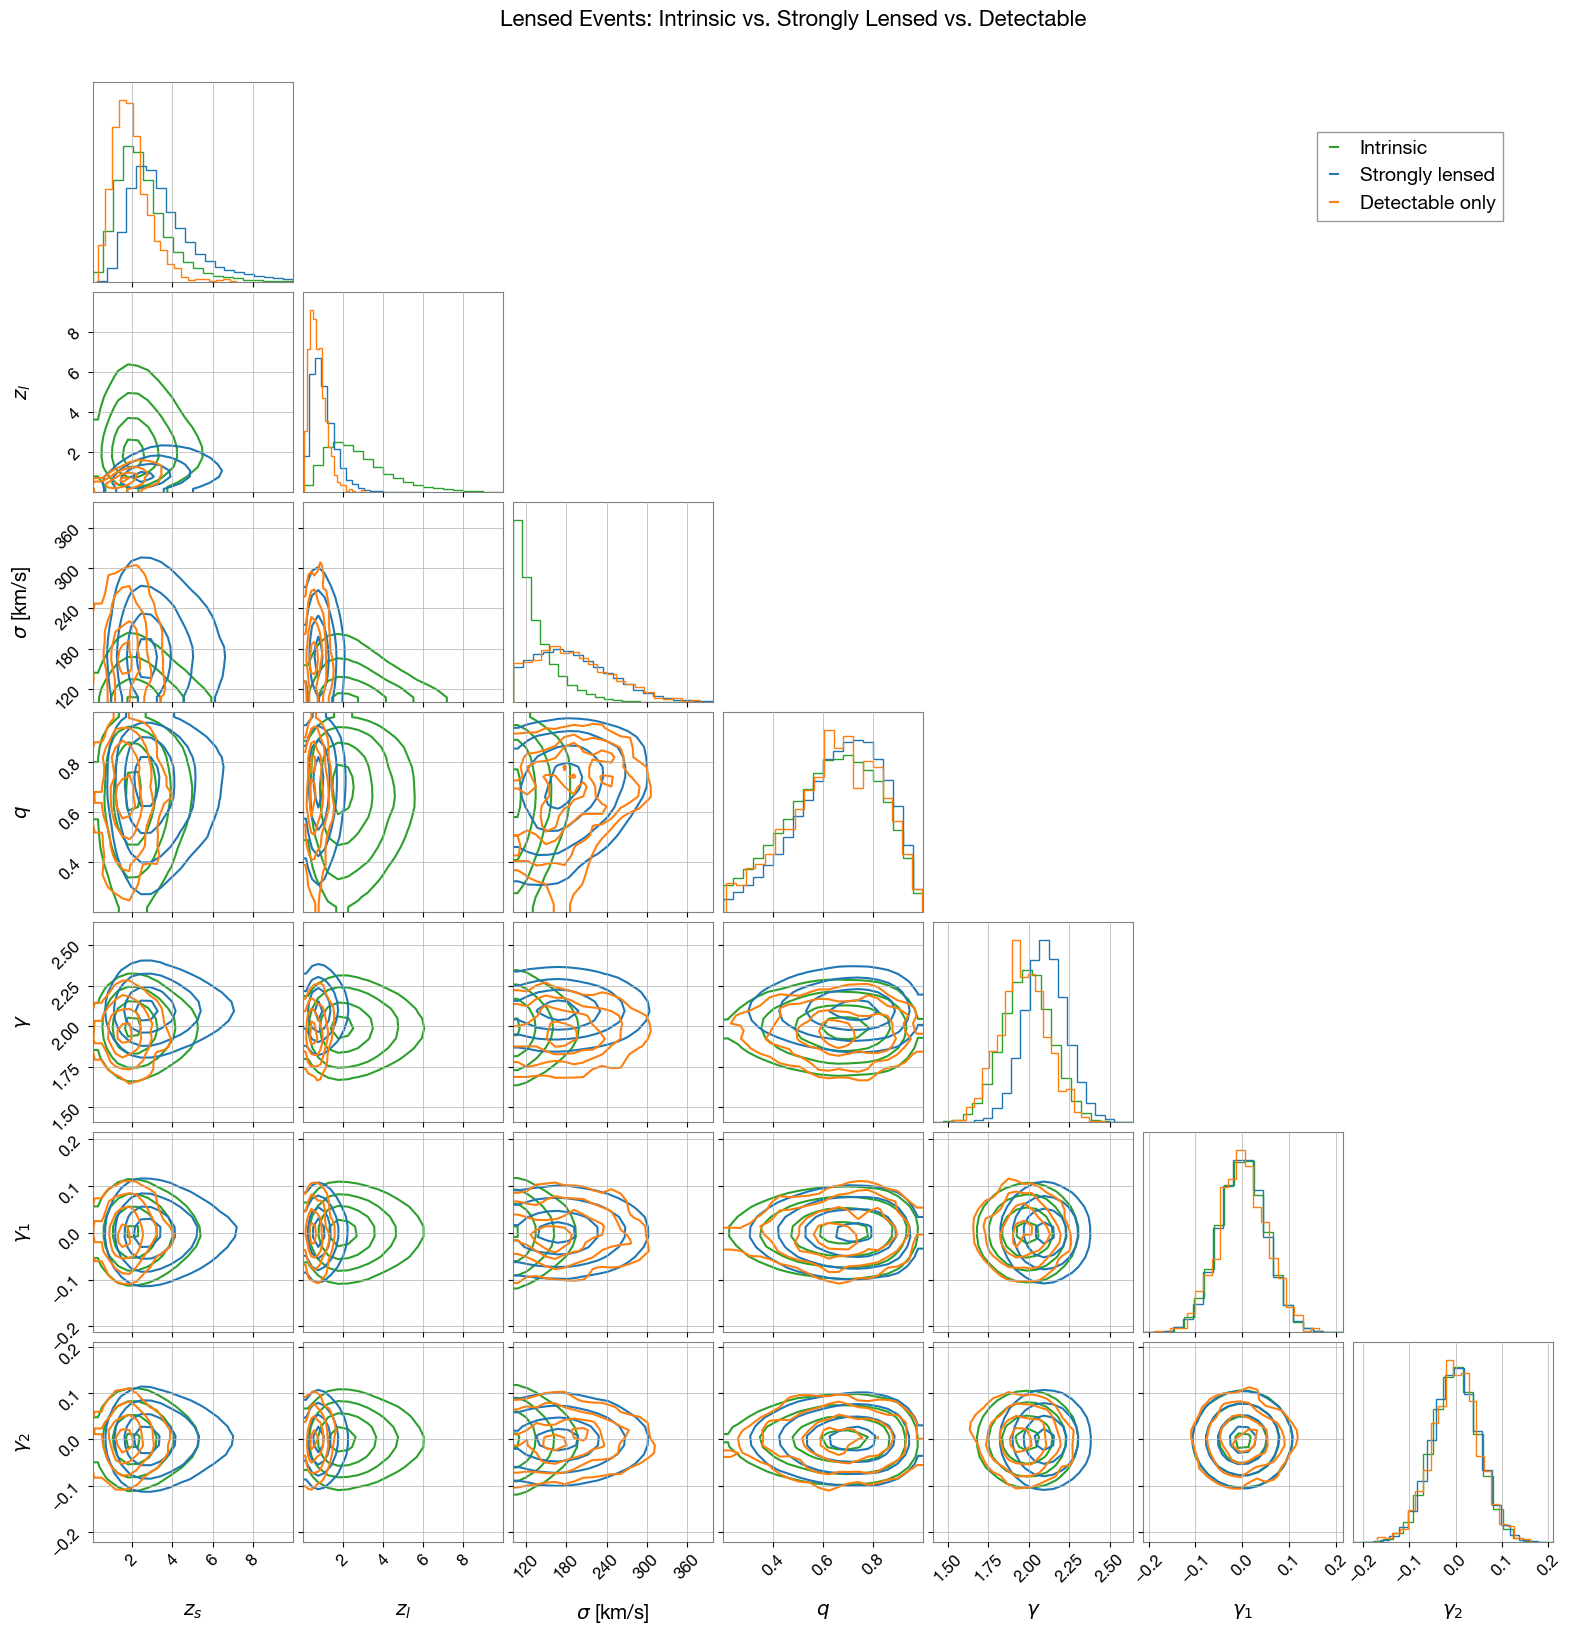

In [3]:
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from ler.utils import get_param_from_json

# Load data
param = get_param_from_json('./ler_data/lensed_params_all.json')
param_detectable = get_param_from_json('./ler_data/lensed_params_n_detectable.json')
param_intrinsic = get_param_from_json('./ler_data/lensed_param_intrinsic.json')
# lensed_param_intrinsic is already in memory from cell 24

# Lensing-specific parameters to compare
param_names = ['zs', 'zl', 'sigma', 'q', 'gamma', 'gamma1', 'gamma2']
labels = ['$z_s$', '$z_l$', r'$\sigma$ [km/s]', '$q$', r'$\gamma$', r'$\gamma_1$', r'$\gamma_2$']

# Prepare data for corner plot
samples_intrinsic = np.stack([param_intrinsic[p] for p in param_names], axis=1)
samples_all = np.stack([param[p] for p in param_names], axis=1)
samples_detectable = np.stack([param_detectable[p] for p in param_names], axis=1)

# Create corner plot for intrinsic events
fig = corner.corner(
    samples_intrinsic, 
    labels=labels, 
    color='C2', 
    alpha=0.5,
    plot_density=False, 
    plot_datapoints=False, 
    smooth=0.8,
    hist_kwargs={'density': True}
)

# Overlay strongly lensed events
corner.corner(
    samples_all, 
    labels=labels, 
    color='C0', 
    alpha=0.5,
    fig=fig,
    plot_density=False, 
    plot_datapoints=False, 
    smooth=0.8,
    hist_kwargs={'density': True}
)

# Overlay detectable events
corner.corner(
    samples_detectable, 
    labels=labels, 
    color='C1', 
    alpha=0.5,
    fig=fig, 
    plot_density=False, 
    plot_datapoints=False, 
    smooth=0.8,
    hist_kwargs={'density': True}
)

# Add legend
green_line = mlines.Line2D([], [], color='C2', label='Intrinsic')
blue_line = mlines.Line2D([], [], color='C0', label='Strongly lensed')
orange_line = mlines.Line2D([], [], color='C1', label='Detectable only')
fig.legend(handles=[green_line, blue_line, orange_line], loc='upper right', 
           bbox_to_anchor=(0.95, 0.95), fontsize=14)
fig.suptitle('Lensed Events: Intrinsic vs. Strongly Lensed vs. Detectable', fontsize=16, y=1.02)

plt.show()

---

## 4. Visualizing Lensed Detectable Events

Visualize properties of detectable lensed events. An example event is highlighted in each plot to show individual characteristics within the population.

### 4.1 Redshift Distribution

Compare redshift distributions of intrinsic and detected populations.

In [ ]:
from ler.utils import get_param_from_json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

np.random.seed(100)

# Load data
unlensed_params_det = get_param_from_json('./ler_data/unlensed_params_n_detectable.json')
lensed_params_det = get_param_from_json('./ler_data/lensed_params_n_detectable.json')
unlensed_params = get_param_from_json('./ler_data/unlensed_param.json')
lensed_params = get_param_from_json('./ler_data/lensed_param.json')
lensed_params_intrinsic = get_param_from_json('./ler_data/lensed_param_intrinsic.json')

bbh_pop_intrinsic = unlensed_params['zs']
unlensed_bbh_pop_detected = unlensed_params_det['zs']
lensed_bbh_pop_detected = lensed_params_det['zs']
lens_detected = lensed_params_det['zl']
lens_dist_intrinsic = lensed_params_intrinsic['zl']

# create gaussian kde
from scipy.stats import gaussian_kde
bandwidth = 0.4
kde_bbh_pop_intrinsic = gaussian_kde(bbh_pop_intrinsic, bw_method=bandwidth)
kde_unlensed_bbh_pop_detected = gaussian_kde(unlensed_bbh_pop_detected, bw_method=bandwidth)
kde_lensed_bbh_pop_detected = gaussian_kde(lensed_bbh_pop_detected, bw_method=bandwidth)
kde_lens_dist_intrinsic = gaussian_kde(lens_dist_intrinsic, bw_method=bandwidth)
kde_lens_detected = gaussian_kde(lens_detected, bw_method=bandwidth)

# Choose a random detected lensed event to highlight
pdet = lensed_params_det['pdet_net']
idx_4img = pdet > 0.5
idx_4img = np.sum(idx_4img, axis=1) ==2 # 2 images detected
chosen_idx_list = np.where(idx_4img)[0]
chosen_idx = chosen_idx_list[10]  # pick the 10th one for consistency
print(f"Chosen detected lensed event index: {chosen_idx}")

# ---------- Data ----------
z = np.linspace(0, 5, 1000)

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(8, 4))

colors = {
    "black": "#000000",
    "violet": "#7E57C2",
    "brown": "#8D6E63",
    "grey": "#616161",
    "red": "#E53935",
    "blue": "#1E88E5",
}

# intrinsic distributions
ax.plot(z, kde_bbh_pop_intrinsic(z), label='Intrinsic BBH population',
        color=colors["grey"], linestyle='--', linewidth=1.2)
ax.plot(z, kde_lens_dist_intrinsic(z), label='Intrinsic Lens population',
        color=colors["brown"], linestyle='--', linewidth=1.2)

# detected distributions
ax.plot(z, kde_unlensed_bbh_pop_detected(z), label='Detected Unlensed BBH population',
        color=colors["black"], linestyle='-', linewidth=1.4)
ax.plot(z, kde_lensed_bbh_pop_detected(z), label='Detected Lensed BBH population',
        color=colors["red"], linestyle='-', linewidth=1.4)
ax.plot(z, kde_lens_detected(z), label='Lenses associated with detectable events',
        color=colors["violet"], linestyle='-', linewidth=1.4)

# Example detected lensed event redshifts
ax.axvline(lensed_params_det['zs'][chosen_idx],
           color=colors["red"], linestyle=':', linewidth=2,
           label='Example detected lensed event source redshift')
ax.axvline(lensed_params_det['zl'][chosen_idx],
           color=colors["brown"], linestyle=':', linewidth=2,
           label='Example detected lensed event lens redshift')

# ---------- Legend ----------
legend = ax.legend(
    handlelength=2.0,
    loc='upper right',
    bbox_to_anchor=(1, 1),
    frameon=True,
    fontsize=10.,
    edgecolor='lightgray'
)
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
for handle in legend.get_lines():
    handle.set_linewidth(1.5)
    handle.set_alpha(0.8)

# ---------- Axes labels, limits, and grid ----------
ax.set_xlabel(r'Redshift $z$', fontsize=11)
ax.set_ylabel(r'Probability Density', fontsize=11)
ax.set_xlim(0, 5)
ax.set_ylim(0, None)

ax.grid(alpha=0.4, linestyle='--', linewidth=0.5)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# add title
ax.set_title('Redshift Distributions of BBH and Lens Populations', fontsize=12)

plt.tight_layout()
# plt.savefig('lens_paramters_baseline_redshift_distributions.svg',
#             dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### 4.2 Magnification Ratio vs Time Delay 

Relative magnification vs time delay distinguishes lensed from unlensed events.

In [ ]:
from ler.utils import relative_mu_dt_unlensed, relative_mu_dt_lensed, mu_vs_dt_plot

# for unlensed detectable events
dmu_unlensed, dt_unlensed = relative_mu_dt_unlensed(param=unlensed_params_det)

# for lensed detectable events
lensed_dict = relative_mu_dt_lensed(lensed_param=lensed_params_det)
dt_lensed = np.concatenate((lensed_dict['dt_rel0'], lensed_dict['dt_rel90']))
dmu_lensed = np.concatenate((lensed_dict['mu_rel0'], lensed_dict['mu_rel90']))

# chosen example index for 4 images, find time delays and magnifications
chosen_lens_dt = lensed_params_det['time_delays'][chosen_idx]
chosen_lens_mu = lensed_params_det['magnifications'][chosen_idx]
pdet = lensed_params_det['pdet_net'][chosen_idx]

dt_lensed_chosen = np.log10((chosen_lens_dt[2]-chosen_lens_dt[1])/ (60 * 60 * 24))
dmu_lensed_chosen = np.log10(abs(chosen_lens_mu[2]/chosen_lens_mu[1]))

# ---------------------------------------
# Plot Magnification ratio Vs Time Delay
# ---------------------------------------
fig, ax = plt.subplots(figsize=(8, 4))

colors = {
    "black": "#000000",
    "violet": "#7E57C2",
    "brown": "#8D6E63",
    "grey": "#616161",
    "red": "#E53935",
    "blue": "#1E88E5",
}

# Use your existing helper without modification
mu_vs_dt_plot(dt_unlensed, dmu_unlensed, colors=[colors['black']]*5)
mu_vs_dt_plot(dt_lensed,   dmu_lensed,   colors=[colors['violet']]*5)

# Proxy artists for legend
# Proxy artists for legend
ax.plot([], [], color=colors['black'],  linestyle='-', label='Unlensed detectable events', linewidth=1.5)
ax.plot([], [], color=colors['violet'], linestyle='-', label='Lensed detectable events',   linewidth=1.5)


# Chosen example point
ax.scatter(
    dt_lensed_chosen, dmu_lensed_chosen,
    color=colors['red'], marker='*', s=110, linewidths=0.6,
    label='Example detected lensed event'
)

# ---------- Legend ----------
legend = ax.legend(
    handlelength=1.5,
    loc='upper left',
    bbox_to_anchor=(0, 1),
    frameon=True,
    fontsize=10,
    edgecolor='lightgray'
)
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
for handle in legend.get_lines():
    handle.set_linewidth(1.6)
    handle.set_alpha(0.85)

# add title
ax.set_title('Magnification ratio Vs Time Delay distribution \nof Lensed and Unlensed events', fontsize=12)

# ---------- Axes, ticks, grid ----------
ax.set_xlabel(r'$\log_{10}(\Delta t_{ij} \,/\, \mathrm{days})$')
ax.set_ylabel(r'$\log_{10}(|\mu_i / \mu_j|)$')
ax.set_xlim(-5, 2.5)
ax.set_ylim(-2, 2)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(alpha=0.38, linestyle='--', linewidth=0.5)

plt.tight_layout()
# plt.savefig('mu_vs_dt_science_ieee.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()
# time: 32s

### 4.3 Caustic Plot

Lens configuration for an example event, showing caustics, critical curves, and image positions.

In [25]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.Solver.epl_shear_solver import caustics_epl_shear
# import phi_q2_ellipticity
from lenstronomy.Util.param_util import phi_q2_ellipticity

# ---------- Custom color palette ----------
colors = {
    "black": "#000000",
    "violet": "#7E57C2",
    "brown":  "#8D6E63",
    "grey":   "#616161",
    "red":    "#E53935",
    "blue":   "#1E88E5",
    "green":  "#43A047",
    "orange": "#FB8C00",
}

# ----- Lens setup -----
lens_model_list = ["EPL", "SHEAR"]
lensModel = LensModel(lens_model_list=lens_model_list)
lens_eq_solver = LensEquationSolver(lensModel)

q   = lensed_params_det['q'][chosen_idx]
phi = lensed_params_det['phi'][chosen_idx]
e1, e2 = phi_q2_ellipticity(phi, q)
kwargs_spep = {
    'theta_E': 1.0,
    'e1': e1,
    'e2': e2,
    'gamma': lensed_params_det['gamma'][chosen_idx],
    'center_x': 0.0,
    'center_y': 0.0,
}
kwargs_shear = {
    'gamma1': lensed_params_det['gamma1'][chosen_idx],
    'gamma2': lensed_params_det['gamma2'][chosen_idx]
}
kwargs_lens = [kwargs_spep, kwargs_shear]

# ----- Solve image configuration -----
theta_E = lensed_params_det['theta_E'][chosen_idx]
# unscaled source position
beta_ra  = lensed_params_det['x_source'][chosen_idx]/theta_E
beta_dec = lensed_params_det['y_source'][chosen_idx]/theta_E
theta_ra, theta_dec = lens_eq_solver.image_position_from_source(
    sourcePos_x=beta_ra, sourcePos_y=beta_dec, kwargs_lens=kwargs_lens,
    solver="analytical", magnification_limit=1.0/100.0, arrival_time_sort=True
)
magnifications = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)
magnifications = np.abs(np.array(magnifications))
# print(f"Magnifications calculated: {magnifications}")

# ----- Figure -----
fig, ax = plt.subplots(figsize=(8, 6))  # wider figure

# Caustics
cp = caustics_epl_shear(kwargs_lens, return_which="double", maginf=-100)
ax.plot(cp[0], cp[1], color=colors['brown'], linewidth=1.5, linestyle='--', label='Double Caustic')
cp = caustics_epl_shear(kwargs_lens, return_which="quad", maginf=-100)
ax.plot(cp[0], cp[1], color=colors['violet'], linewidth=1.5, linestyle='-', label='Quad Caustic')

# Einstein ring
theta_E = 1.0
circle = plt.Circle((0, 0), theta_E, color=colors['grey'], fill=False,
                    linestyle='dotted', linewidth=1.5, label='Einstein Ring')
ax.add_artist(circle)

# Source position
ax.plot(beta_ra, beta_dec, marker='x', ls='None', color=colors['red'], label='Source', markersize=10)

# Image positions
img_colors = [colors['blue'], colors['violet'], colors['brown'], colors['black']]
pdet_image = lensed_params_det['pdet_net'][chosen_idx]
for i in range(len(theta_ra)):
    if pdet_image[i] >= 0.5:
        ax.plot(theta_ra[i], theta_dec[i], marker='*', ls='None',
                color=img_colors[i % len(img_colors)],
                label=f'Image {i+1} (detected)\nMagnification: {magnifications[i]:.1f}', markersize=15)
    else:
        ax.plot(theta_ra[i], theta_dec[i], marker='.', ls='None',
                color=img_colors[i % len(img_colors)],
                label=f'Image {i+1} (not detected)\nMagnification: {magnifications[i]:.1f}', markersize=10)
# Axes & Grid
ax.set_xlabel('RA [arcsec]')
ax.set_ylabel('Dec [arcsec]')
dim_x, dim_y = 1.8, 1.5  # rectangular window
ax.set_xlim(-dim_x, dim_x)
ax.set_ylim(-dim_y, dim_y)

# Relax the aspect ratio → visually rectangular (with adjustable='box' to respect figure size)
ax.set_aspect(6/8, adjustable='box')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(alpha=0.4, linestyle='--', linewidth=0.6)

# Legend on the side
legend = ax.legend(
    handlelength=2.5,
    loc='center left',
    bbox_to_anchor=(1.03, 0.5),
    frameon=True,
    fontsize=12,
    edgecolor='lightgray',
    numpoints=1,  # Show only one marker per legend entry
    scatterpoints=1
)
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
for handle in legend.get_lines():
    handle.set_linewidth(1.5)
    handle.set_alpha(0.85)
# add title
ax.set_title('Lens Configuration for Example Detected Lensed Event', fontsize=14)
plt.tight_layout()
# plt.savefig('lens_configuration_rectangular.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

NameError: name 'lensed_params_det' is not defined

---

## 5. Summary

This notebook demonstrated advanced sampling capabilities of **LeR** for generating detectable GW events.

**Key Takeaways:**

1. **N-Event Sampling:** `selecting_n_unlensed_detectable_events` and `selecting_n_lensed_detectable_events` collect a target number of detectable events with convergence monitoring.

2. **Rate Convergence:** Tracking rates across batches verifies statistical stability.

3. **Resume Capability:** Sampling can be interrupted and resumed without losing progress.

4. **Selection Effects**: The corner plots reveal how detector sensitivity and strong lensing selection bias the observed populations:
   - **Detector sensitivity effects:**
     - Lower redshift events are preferentially detected
     - Higher mass events have higher detection probability
     - Sky location and orientation effects are visible
   - **Strong lensing selection effects:**
     - Higher magnification events are more likely to be detected
     - Lensed events tend to occur at higher redshifts
     - Lens velocity dispersion influences strong lensing due to increased lensing cross-section
     - Lens galaxy density profile slope affects detectability

5. **Lensing Visualization**: The redshift distributions, magnification-time delay plots, and caustic diagrams provide insight into the properties of detectable lensed events.


In [ ]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.Solver.epl_shear_solver import caustics_epl_shear
# import phi_q2_ellipticity
from lenstronomy.Util.param_util import phi_q2_ellipticity

In [23]:
import io
import ipywidgets as widgets
from ipywidgets import FloatSlider, VBox, HBox, Output, Image
from IPython.display import display
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.Solver.epl_shear_solver import caustics_epl_shear
from lenstronomy.Util.param_util import phi_q2_ellipticity
import numpy as np
import matplotlib
matplotlib.use('agg')  # non-interactive backend — we render to PNG manually
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# ---------- Custom color palette ----------
colors = {
    "black": "#000000",
    "violet": "#7E57C2",
    "brown":  "#8D6E63",
    "grey":   "#616161",
    "red":    "#E53935",
    "blue":   "#1E88E5",
    "green":  "#43A047",
    "orange": "#FB8C00",
}

# ----- Lens setup -----
lens_model_list = ["EPL", "SHEAR"]
lensModel = LensModel(lens_model_list=lens_model_list)
lens_eq_solver = LensEquationSolver(lensModel)

# ----- Create sliders -----
q_slider      = FloatSlider(value=0.6,      min=0.1,  max=0.99,   step=0.01, description='q:',      continuous_update=False)
phi_slider    = FloatSlider(value=np.pi/6,  min=0.,   max=np.pi,  step=0.05, description='φ:',    continuous_update=False)
gamma_slider  = FloatSlider(value=1.84,     min=1.5,  max=2.5,    step=0.01, description='γ:',  continuous_update=False)
gamma1_slider = FloatSlider(value=-0.05,    min=-0.2, max=0.2,    step=0.01, description='γ₁:', continuous_update=False)
gamma2_slider = FloatSlider(value=-0.05,    min=-0.2, max=0.2,    step=0.01, description='γ₂:', continuous_update=False)
beta_ra_slider  = FloatSlider(value=-0.25,  min=-1.5, max=1.5,    step=0.05, description='βₓ:',  continuous_update=False)
beta_dec_slider = FloatSlider(value=0.0,    min=-1.5, max=1.5,    step=0.05, description='βᵧ:', continuous_update=False)

# ----- Image widget to hold the plot (single render target) -----
# Fixed size: 8*150=1200px width, 6*150=900px height (matches figsize and dpi)
img_widget = Image(format='png', width='800px', height='800px')

def plot_lens_config(change=None):
    q = q_slider.value
    phi = phi_slider.value
    gamma = gamma_slider.value
    gamma1 = gamma1_slider.value
    gamma2 = gamma2_slider.value
    beta_ra = beta_ra_slider.value
    beta_dec = beta_dec_slider.value

    e1, e2 = phi_q2_ellipticity(phi, q)
    kwargs_spep = {
        'theta_E': 1.0,
        'e1': e1, 'e2': e2,
        'gamma': gamma,
        'center_x': 0.0, 'center_y': 0.0,
    }
    kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}
    kwargs_lens = [kwargs_spep, kwargs_shear]

    fig, ax = plt.subplots(figsize=(7, 7))

    try:
        theta_ra, theta_dec = lens_eq_solver.image_position_from_source(
            sourcePos_x=beta_ra, sourcePos_y=beta_dec, kwargs_lens=kwargs_lens,
            solver="analytical", magnification_limit=1.0/100.0, arrival_time_sort=True
        )
        magnifications = np.abs(np.array(lensModel.magnification(theta_ra, theta_dec, kwargs_lens)))
    except Exception:
        theta_ra, theta_dec, magnifications = [], [], []

    try:
        cp = caustics_epl_shear(kwargs_lens, return_which="double", maginf=-100)
        ax.plot(cp[0], cp[1], color='C1', linewidth=1.5, linestyle='--', label='Double Caustic')
    except Exception:
        pass
    try:
        cp = caustics_epl_shear(kwargs_lens, return_which="quad", maginf=-100)
        ax.plot(cp[0], cp[1], color='C2', linewidth=1.5, linestyle='-', label='Quad Caustic')
    except Exception:
        pass

    circle = plt.Circle((0, 0), 1.0, color='C0', fill=False,
                        linestyle='dotted', linewidth=1.5, label='Einstein Ring')
    ax.add_artist(circle)
    ax.plot(beta_ra, beta_dec, marker='x', ls='None', color='C3', label='Source', markersize=10)

    img_colors = [colors['blue'], colors['violet'], colors['brown'], colors['grey']]
    for i in range(len(theta_ra)):
        ax.plot(theta_ra[i], theta_dec[i], marker='*', ls='None',
                color=img_colors[i % len(img_colors)],
                label=f'Image {i+1}\n'+rf'$\mid \mu_{i+1}\mid = {magnifications[i]:.1f}$', markersize=10)

    # Axes & Grid
    ax.set_xlabel('x [arcsec]')
    ax.set_ylabel('y [arcsec]')
    dim_x, dim_y = 1.6, 1.6  # rectangular window
    ax.set_xlim(-dim_x, dim_x)
    ax.set_ylim(-dim_y, dim_y)
    ax.set_aspect(1, adjustable='box')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(alpha=0.4, linestyle='--', linewidth=0.6)

    legend = ax.legend(
        handlelength=2.5, loc='center left', bbox_to_anchor=(1.03, 0.5),
        frameon=True, fontsize=12, edgecolor='lightgray', numpoints=1, scatterpoints=1
    )
    legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
    for handle in legend.get_lines():
        handle.set_linewidth(1.5)
        handle.set_alpha(0.85)

    ax.set_title(r'Interactive Lens Configuration ($\theta_E$ fixed at 1.0 rad)', fontsize=14)
    fig.tight_layout()

    # Render figure to PNG bytes and push into the Image widget
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    img_widget.value = buf.read()

# ----- Connect sliders -----
for s in [q_slider, phi_slider, gamma_slider, gamma1_slider, gamma2_slider, beta_ra_slider, beta_dec_slider]:
    s.observe(plot_lens_config, names='value')

# ----- Layout -----
sliders_vertical = VBox([q_slider, phi_slider, gamma_slider, gamma1_slider, gamma2_slider, beta_ra_slider, beta_dec_slider])
display(VBox([sliders_vertical, img_widget]))

# ----- Draw initial plot -----
plot_lens_config()

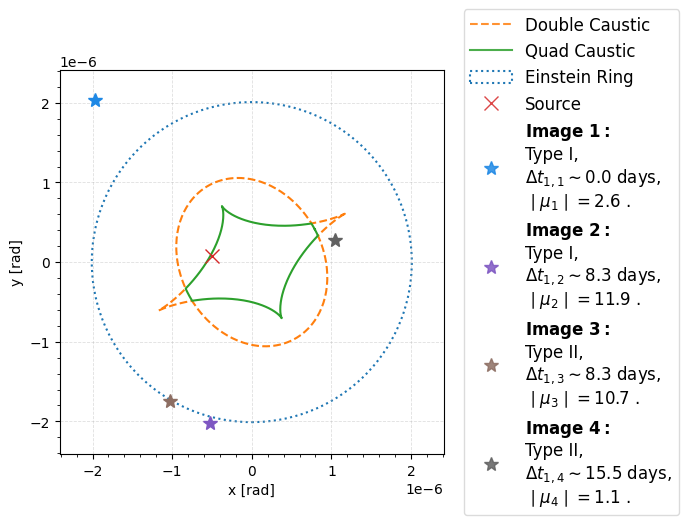

In [38]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.Solver.epl_shear_solver import caustics_epl_shear
# import phi_q2_ellipticity
from lenstronomy.Util.param_util import phi_q2_ellipticity
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# ---------- Custom color palette ----------
colors = {
    "black": "#000000",
    "violet": "#7E57C2",
    "brown":  "#8D6E63",
    "grey":   "#616161",
    "red":    "#E53935",
    "blue":   "#1E88E5",
    "green":  "#43A047",
    "orange": "#FB8C00",
}

# find theta_E
sigma = 160.0  # km/s
zs = 3.0
zl = 0.8
# use astropy to find angular diameter distances
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
D_s = cosmo.angular_diameter_distance(zs).to('Mpc').value
D_l = cosmo.angular_diameter_distance(zl).to('Mpc').value
D_ls = cosmo.angular_diameter_distance_z1z2(zl, zs).to('Mpc').value
theta_E = 4 * np.pi * (sigma/299792.458)**2 * D_ls / D_s  # in radians

# ----- Lens setup -----
lens_model_list = ["EPL", "SHEAR"]
lensModel = LensModel(lens_model_list=lens_model_list, z_lens=zl, z_source=zs)
lens_eq_solver = LensEquationSolver(lensModel)

q   = 0.6
phi = 0.52
e1, e2 = phi_q2_ellipticity(phi, q)

# theta_E = 1.0  # rescale to 1.0 for plotting
kwargs_spep = {
    'theta_E': theta_E,
    'e1': e1,
    'e2': e2,
    'gamma': 1.84,
    'center_x': 0.0,
    'center_y': 0.0,
}
kwargs_shear = {
    'gamma1': -0.05,
    'gamma2': -0.05,
}
kwargs_lens = [kwargs_spep, kwargs_shear]

# ----- Solve image configuration -----
# unscaled source position
beta_ra  = -0.25*theta_E
beta_dec = 0.04*theta_E
# image positions (in units of theta_E) and magnifications
theta_ra, theta_dec = lens_eq_solver.image_position_from_source(
    sourcePos_x=beta_ra, sourcePos_y=beta_dec, kwargs_lens=kwargs_lens,
    solver="analytical", magnification_limit=1.0/100.0, arrival_time_sort=True
)
magnifications = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)
magnifications = np.abs(np.array(magnifications))
# print(f"Magnifications calculated: {magnifications}")

# Compute hessian properties for image type classification
hessian = lensModel.hessian(theta_ra, theta_dec, kwargs_lens)
determinant = np.array(
    (1 - hessian[0]) * (1 - hessian[3]) - hessian[1] * hessian[2]
)
trace = np.array(2 - hessian[0] - hessian[3])
# image type classification (morse phase)
nImages = len(theta_ra)
image_type = np.empty(nImages, dtype=object)  # 4 images max for EPL+shear
nImages = len(theta_ra)
for j in range(nImages):
    if determinant[j] < 0:
        image_type[j] = 'II'
    elif trace[j] > 0:
        image_type[j] = 'I'
    elif trace[j] < 0:
        image_type[j] = 'III'
    else:
        image_type[j] = np.nan

radian_to_arcseconds = 180.0 / np.pi * 3600.0
days_to_seconds = 24.0 * 3600.0
time_delays = (
        lensModel.arrival_time(theta_ra, theta_dec, kwargs_lens)
        * (1.0 * radian_to_arcseconds) ** 2
        * days_to_seconds
    )
seconds_to_days = 1.0 / (24.0 * 3600.0)
delta_time_1i = (time_delays - time_delays[0]) * seconds_to_days  # relative to the first image in days

# nImages = len(theta_ra)
# # Compute magnifications and time delays
# # theta_E_nImages = theta_E_original * np.ones(nImages)
# radian_to_arcseconds = 180.0 / np.pi * 3600.0
# days_to_seconds = 24.0 * 3600.0
# time_delays = (
#         lensModel.arrival_time(theta_ra, theta_dec, kwargs_lens)
#         * (theta_E_original * radian_to_arcseconds) ** 2
#         * days_to_seconds
#     )
# delta_time_1i = time_delays - time_delays[0]  # relative to the first image

# # rescale source and image positions 
# beta_ra  = beta_ra/theta_E_original
# beta_dec = beta_dec/theta_E_original
# theta_ra = np.array(theta_ra)/theta_E_original
# theta_dec = np.array(theta_dec)/theta_E_original    

# ----- Figure -----
fig, ax = plt.subplots(figsize=(7, 7))  # wider figure

# Caustics
cp = caustics_epl_shear(kwargs_lens, return_which="double", maginf=-100)
ax.plot(cp[0], cp[1], color='C1', linewidth=1.5, linestyle='--', label='Double Caustic')
cp = caustics_epl_shear(kwargs_lens, return_which="quad", maginf=-100)
ax.plot(cp[0], cp[1], color='C2', linewidth=1.5, linestyle='-', label='Quad Caustic')

# Einstein ring
circle = plt.Circle((0, 0), theta_E, color='C0', fill=False,
                    linestyle='dotted', linewidth=1.5, label='Einstein Ring')
ax.add_artist(circle)

# Source position
ax.plot(beta_ra, beta_dec, marker='x', ls='None', color='C3', label='Source', markersize=10)

# Image positions
img_colors = [colors['blue'], colors['violet'], colors['brown'], colors['grey']]

for i in range(len(theta_ra)):
    ax.plot(
        theta_ra[i], theta_dec[i], marker='*', ls='None',
        color=img_colors[i % len(img_colors)],
        label=(
            rf'$\bf{{Image\ {i+1}:}}$'
            + f'\nType {image_type[i]},'
            + f'\n' + rf'$\Delta t_{{1,{i+1}}} \sim {delta_time_1i[i]:.1f}$ days,'
            + f'\n' + rf'$\mid \mu_{i+1}\mid = {magnifications[i]:.1f}$ .'
        ),
        markersize=10
    )
# Axes & Grid
ax.set_xlabel('x [rad]')
ax.set_ylabel('y [rad]')
dim_x, dim_y = theta_E*1.2, theta_E*1.2  # rectangular window
ax.set_xlim(-dim_x, dim_x)
ax.set_ylim(-dim_y, dim_y)

# Relax the aspect ratio → visually rectangular (with adjustable='box' to respect figure size)
ax.set_aspect(1, adjustable='box')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(alpha=0.4, linestyle='--', linewidth=0.6)

# Legend on the side
legend = ax.legend(
    handlelength=2.5,
    loc='center left',
    bbox_to_anchor=(1.03, 0.5),
    frameon=True,
    fontsize=12,
    edgecolor='lightgray',
    numpoints=1,  # Show only one marker per legend entry
    scatterpoints=1
)
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
for handle in legend.get_lines():
    handle.set_linewidth(1.5)
    handle.set_alpha(0.85)

plt.tight_layout()
plt.savefig('lens_configuration.jpg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

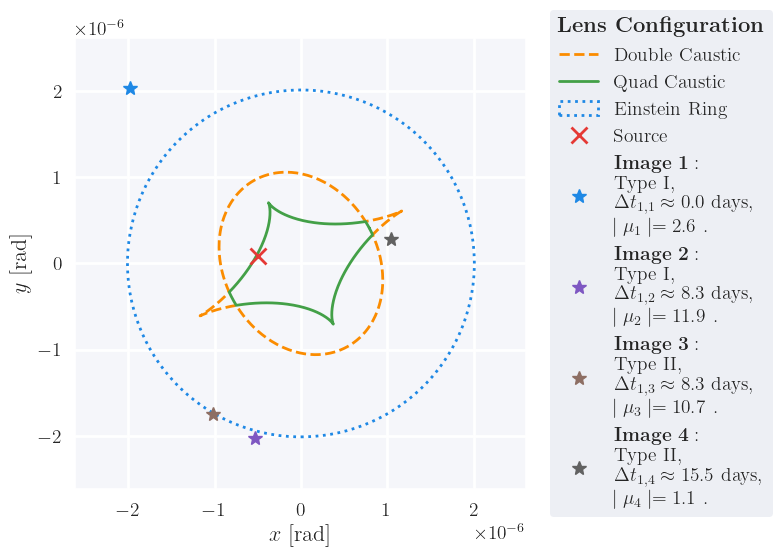

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.Solver.epl_shear_solver import caustics_epl_shear
from lenstronomy.Util.param_util import phi_q2_ellipticity
from astropy.cosmology import LambdaCDM
from matplotlib.ticker import AutoMinorLocator

# ==========================================
# 1. STYLE CONFIGURATION
# ==========================================
# Reset defaults first to avoid conflicts
mpl.rcParams.update(mpl.rcParamsDefault)

LIGHT_BG = "#F5F6FA"   # panel background
LEG_BG   = "#E9EBF2"   # legend background

# Apply Seaborn Theme
sns.set_theme(
    style="darkgrid",
    context="notebook",
    rc={
        "axes.facecolor": LIGHT_BG,
        "figure.facecolor": "white",
        "axes.grid": True,
        "grid.color": "white",
        "grid.linestyle": "-",
        "grid.linewidth": 2.0,
        "grid.alpha": 1.0,
        "axes.axisbelow": True,
        "xtick.direction": "out",
        "ytick.direction": "out",
    }
)

# Apply LaTeX and Font Settings
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "custom",
    "savefig.dpi": 300,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,     # Slightly smaller to fit the complex labels
    "legend.title_fontsize": 16,
    "axes.titlesize": 18
})

# Custom color palette from your logic
colors = {
    "black": "#000000",
    "violet": "#7E57C2",
    "brown":  "#8D6E63",
    "grey":   "#616161",
    "red":    "#E53935",
    "blue":   "#1E88E5",
    "green":  "#43A047",
    "orange": "#FB8C00",
}

# ==========================================
# 2. PHYSICS CALCULATIONS
# ==========================================
# Cosmology Setup
sigma = 160.0  # km/s
zs = 3.0
zl = 0.8
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
D_s = cosmo.angular_diameter_distance(zs).to('Mpc').value
D_l = cosmo.angular_diameter_distance(zl).to('Mpc').value
D_ls = cosmo.angular_diameter_distance_z1z2(zl, zs).to('Mpc').value
theta_E_val = 4 * np.pi * (sigma/299792.458)**2 * D_ls / D_s  # in radians

# Lens Setup
lens_model_list = ["EPL", "SHEAR"]
lensModel = LensModel(lens_model_list=lens_model_list, z_lens=zl, z_source=zs)
lens_eq_solver = LensEquationSolver(lensModel)

q   = 0.6
phi = 0.52
e1, e2 = phi_q2_ellipticity(phi, q)

kwargs_spep = {
    'theta_E': theta_E_val,
    'e1': e1, 'e2': e2,
    'gamma': 1.84,
    'center_x': 0.0, 'center_y': 0.0,
}
kwargs_shear = {'gamma1': -0.05, 'gamma2': -0.05}
kwargs_lens = [kwargs_spep, kwargs_shear]

# Solve Image Configuration
beta_ra  = -0.25 * theta_E_val
beta_dec = 0.04 * theta_E_val

theta_ra, theta_dec = lens_eq_solver.image_position_from_source(
    sourcePos_x=beta_ra, sourcePos_y=beta_dec, kwargs_lens=kwargs_lens,
    solver="analytical", magnification_limit=1.0/100.0, arrival_time_sort=True
)
magnifications = np.abs(lensModel.magnification(theta_ra, theta_dec, kwargs_lens))

# Image Type Classification & Time Delays
hessian = lensModel.hessian(theta_ra, theta_dec, kwargs_lens)
determinant = (1 - hessian[0]) * (1 - hessian[3]) - hessian[1] * hessian[2]
trace = 2 - hessian[0] - hessian[3]

image_type = []
for j in range(len(theta_ra)):
    if determinant[j] < 0:
        image_type.append('II')
    elif trace[j] > 0:
        image_type.append('I')
    elif trace[j] < 0:
        image_type.append('III')
    else:
        image_type.append('nan')

radian_to_arcseconds = 180.0 / np.pi * 3600.0
days_to_seconds = 24.0 * 3600.0
time_delays = (
    lensModel.arrival_time(theta_ra, theta_dec, kwargs_lens)
    * (1.0 * radian_to_arcseconds) ** 2
    * days_to_seconds
)
delta_time_1i = (time_delays - time_delays[0]) / days_to_seconds

# ==========================================
# 3. PLOTTING
# ==========================================
fig, ax = plt.subplots(figsize=(8, 8))

# -- Caustics --
cp_double = caustics_epl_shear(kwargs_lens, return_which="double", maginf=-100)
ax.plot(cp_double[0], cp_double[1], color=colors['orange'], linewidth=2.0, linestyle='--', label='Double Caustic')

cp_quad = caustics_epl_shear(kwargs_lens, return_which="quad", maginf=-100)
ax.plot(cp_quad[0], cp_quad[1], color=colors['green'], linewidth=2.0, linestyle='-', label='Quad Caustic')

# -- Einstein Ring --
# Using a circle patch with the specific color style
circle = plt.Circle((0, 0), theta_E_val, color=colors['blue'], fill=False,
                    linestyle='dotted', linewidth=2.0, label='Einstein Ring')
ax.add_artist(circle)

# -- Source Position --
ax.plot(beta_ra, beta_dec, marker='x', ls='None', color=colors['red'], label='Source', markersize=12, markeredgewidth=2)

# -- Image Positions --
img_colors = [colors['blue'], colors['violet'], colors['brown'], colors['grey']]

for i in range(len(theta_ra)):
    ax.plot(
        theta_ra[i], theta_dec[i], marker='*', ls='None',
        color=img_colors[i % len(img_colors)],
        label=(
            rf'$\bf{{Image\ {i+1}:}}$'
            + f'\nType {image_type[i]},'
            + f'\n' + rf'$\Delta t_{{1,{i+1}}} \approx {delta_time_1i[i]:.1f}$ days,'
            + f'\n' + rf'$\mid \mu_{i+1}\mid = {magnifications[i]:.1f}$ .'
        ),
        markersize=10
    )

# -- Axis & Layout --
ax.set_xlabel(r'$x$ [rad]')
ax.set_ylabel(r'$y$ [rad]')

dim = theta_E_val * 1.3
ax.set_xlim(-dim, dim)
ax.set_ylim(-dim, dim)
ax.set_aspect('equal', adjustable='box')

# Minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# -- Legend Styling --
legend = ax.legend(
    loc='center left',
    bbox_to_anchor=(1.03, 0.5),
    frameon=True,
    numpoints=1,
    scatterpoints=1,
    title=r"\textbf{Lens Configuration}"
)

# Apply the custom legend background style
frame = legend.get_frame()
frame.set_facecolor(LEG_BG)
frame.set_edgecolor("none")
frame.set_linewidth(0.0)
frame.set_alpha(0.8)

# -- Save & Show --
plt.tight_layout()
plt.savefig('lens_configuration.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
theta_E

np.float64(2.009429442717487e-06)

In [31]:
delta_time_1i

array([      0.        ,  715997.08525205,  718958.50700447,
       1340294.45161122])

In [10]:
zs = np.array([3.0, 3.0, 3.0, 3.0])
zl = np.array([0.8, 0.8, 0.8, 0.8])
sigma = np.array([160.0, 200.0, 160.0, 200.0])
q = np.array([1., 1., 0.6, 0.6])
phi = np.array([0.0, 0.0, 0.52, 0.52])
gamma = np.array([2.0, 2.0, 1.84, 1.84])
gamma1 = np.array([0.0, 0.0, -0.05, -0.05])
gamma2 = np.array([0.0, 0.0, -0.05, -0.05])

cs =ler.cross_section(zs=zs, zl=zl, sigma=sigma, q=q, phi=phi, gamma=gamma, gamma1=gamma1, gamma2=gamma2)

In [12]:
cs[1]/cs[0], (200.0/160.0)**4, cs[3]/cs[2], (200.0/160.0)**4

(np.float64(2.4414062500000013),
 2.44140625,
 np.float64(2.4414062500000013),
 2.44140625)